In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

In [3]:
train = pd.read_csv('sales_train.csv')
test = pd.read_csv('sales_test.csv')
inventory = pd.read_csv('inventory.csv')
calendar = pd.read_csv('calendar.csv')
weights = pd.read_csv('test_weights.csv')

In [4]:
# Convert 'date' columns to datetime for easier manipulation
train['date'] = pd.to_datetime(train['date'])
calendar['date'] = pd.to_datetime(calendar['date'])
test['date'] = pd.to_datetime(test['date'])

In [5]:
# Merge training data with inventory and calendar data
train = train.merge(inventory, on=['unique_id', 'warehouse'], how='left')  # Add inventory details
train = train.merge(calendar, on=['warehouse', 'date'], how='left')  # Add calendar details

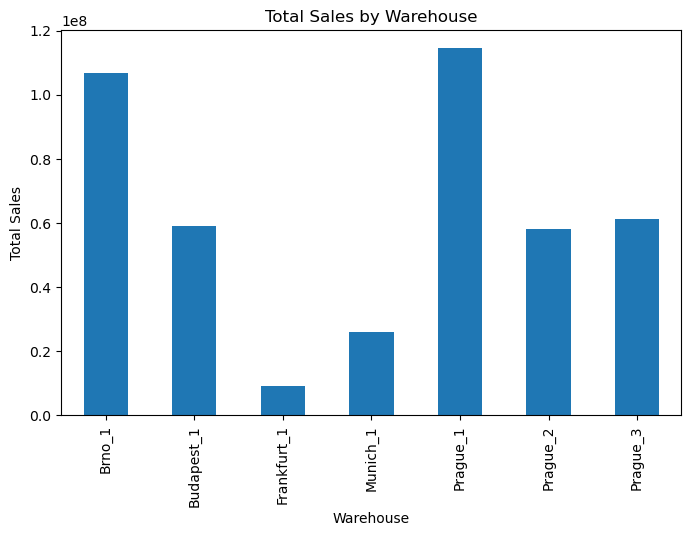

C:\Users\bodin\AppData\Local\Temp\ipykernel_3204\2453116422.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=train_daily, x='date', y='sales', hue='warehouse', ci=None)


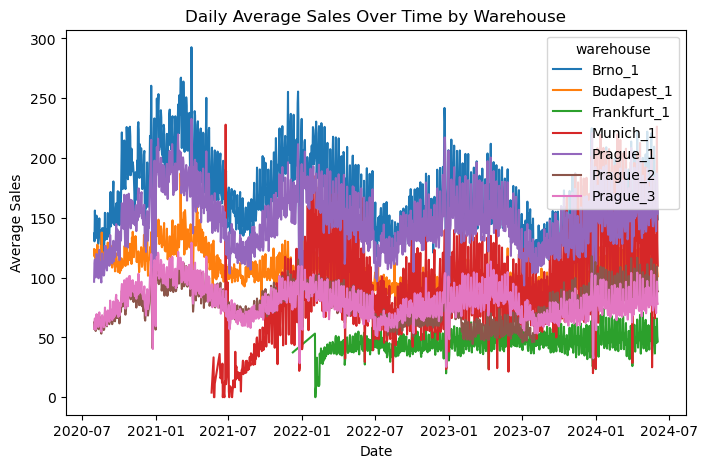

In [6]:
# Sales by warehouse
plt.figure(figsize=(8, 5))
train.groupby('warehouse')['sales'].sum().plot(kind='bar')
plt.title('Total Sales by Warehouse')
plt.xlabel('Warehouse')
plt.ylabel('Total Sales')
plt.show()

train_daily = train.groupby(['warehouse', pd.Grouper(key='date', freq='D')])['sales'].mean().reset_index()
# Plot downsampled data
plt.figure(figsize=(8, 5))
sns.lineplot(data=train_daily, x='date', y='sales', hue='warehouse', ci=None)
plt.title('Daily Average Sales Over Time by Warehouse')
plt.xlabel('Date')
plt.ylabel('Average Sales')
plt.show()

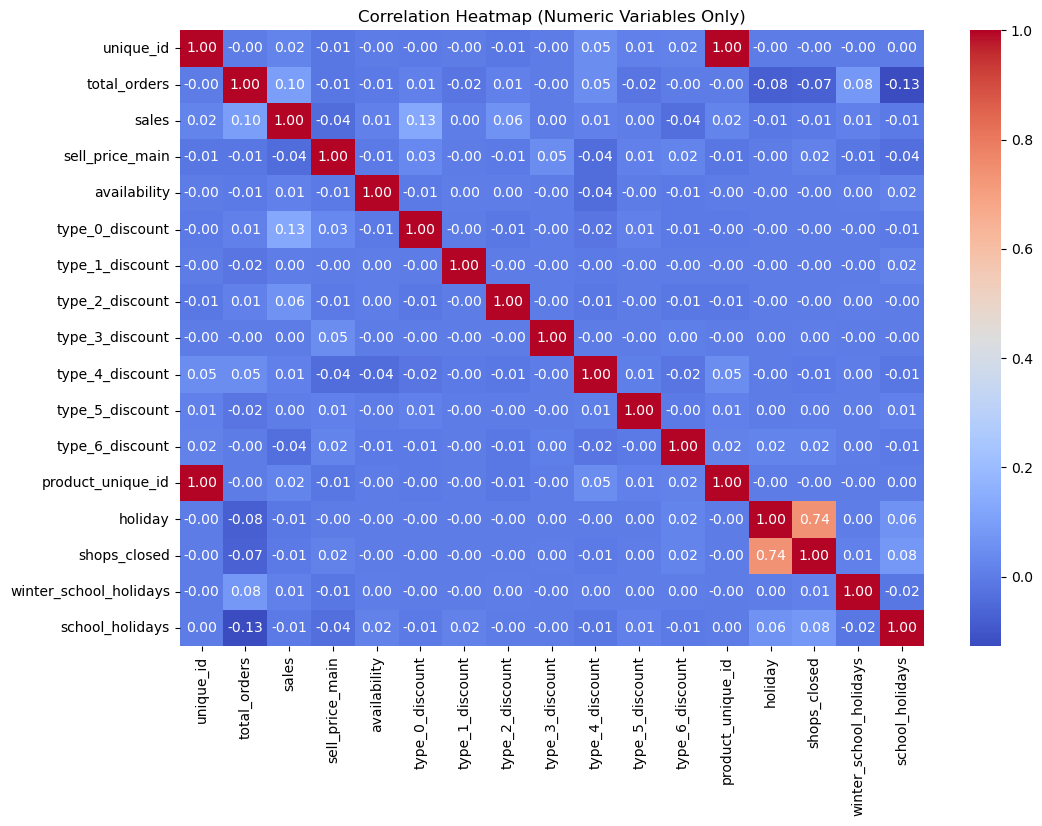

In [7]:
numeric_cols = train.select_dtypes(include=['float64', 'int64']).columns
# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(train[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap (Numeric Variables Only)')
plt.show()

In [8]:
# Feature engineering for training data
train['day_of_week'] = train['date'].dt.dayofweek  # Extract day of the week (0=Monday, 6=Sunday)
train['month'] = train['date'].dt.month  # Extract month
train['is_holiday'] = train['holiday'].apply(lambda x: 1 if x == 1 else 0)  # Flag for holidays

train['lag_1'] = train.groupby('unique_id')['sales'].shift(1)  # Create lagged sales feature on previous day
train['lag_7'] = train.groupby('unique_id')['sales'].shift(7)  # Previous week
# Create rolling average features
train['rolling_7'] = train.groupby('unique_id')['sales'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())

# Create 'max_discount' feature by finding the maximum discount across all discount columns
discount_cols = [col for col in train.columns if 'type_' in col]
train['max_discount'] = train[discount_cols].max(axis=1)
# Create total discount feature
train['total_discount'] = train[discount_cols].sum(axis=1)
# Create discount flag
train['has_discount'] = train['total_discount'].apply(lambda x: 1 if x > 0 else 0)

# Create season feature
train['season'] = train['date'].dt.month % 12 // 3 + 1  # 1=Winter, 2=Spring, 3=Summer, 4=Fall
# Create weekend flag
train['is_weekend'] = train['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Create product popularity feature
product_popularity = train.groupby('product_unique_id')['sales'].sum().reset_index()
product_popularity.rename(columns={'sales': 'product_popularity'}, inplace=True)
train = train.merge(product_popularity, on='product_unique_id', how='left')

In [9]:
train.isna().sum()

unique_id                       0
date                            0
warehouse                       0
total_orders                   52
sales                          52
sell_price_main                 0
availability                    0
type_0_discount                 0
type_1_discount                 0
type_2_discount                 0
type_3_discount                 0
type_4_discount                 0
type_5_discount                 0
type_6_discount                 0
product_unique_id               0
name                            0
L1_category_name_en             0
L2_category_name_en             0
L3_category_name_en             0
L4_category_name_en             0
holiday_name              3844119
holiday                         0
shops_closed                    0
winter_school_holidays          0
school_holidays                 0
day_of_week                     0
month                           0
is_holiday                      0
lag_1                        5442
lag_7         

In [10]:
# Handle missing values
train = train.dropna(subset=['total_orders'])  # Drop rows with missing 'total_orders'
train = train.dropna(subset=['sales'])  # Drop rows with missing 'sales'
# Forward fill lag_1 and lag_7
train['lag_1'] = train.groupby('unique_id')['lag_1'].ffill()
train['lag_7'] = train.groupby('unique_id')['lag_7'].ffill()

# Conditional fill for remaining missing values
train['lag_1'] = train.groupby(['unique_id', 'day_of_week'])['lag_1'].transform(lambda x: x.fillna(x.median()))
train['lag_7'] = train.groupby(['unique_id', 'day_of_week'])['lag_7'].transform(lambda x: x.fillna(x.median()))

train = train.dropna(subset=['lag_1','lag_7'])

In [11]:
X = train[['total_orders', 'sell_price_main', 'max_discount', 'day_of_week', 'is_holiday', 'season', 'is_weekend', 'total_discount', 'has_discount', 'product_popularity']]
y = train['sales']

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Define the model
model = XGBRegressor(random_state=42)

# Define hyperparameters to tune
param_dist = {
    'n_estimators': [100, 200, 300,500],  # Number of boosting rounds
    'max_depth': [3, 5, 7,10],  # Maximum depth of a tree
    'learning_rate': uniform(0.01, 0.3),  # Step size shrinkage
    'subsample': uniform(0.6, 0.4),  # Fraction of samples used for training
    'colsample_bytree': uniform(0.6, 0.4),  # Fraction of features used for training
    'gamma': uniform(0, 0.5),  # Minimum loss reduction required to make a split
    'reg_alpha': uniform(0, 1),  # L1 regularization term
    'reg_lambda': uniform(0, 1),  # L2 regularization term
}

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=20,  # Number of random combinations to try
    scoring='neg_mean_absolute_error',  # Use MAE for evaluation
    cv=5,  # 5-fold cross-validation
    verbose=1,
    random_state=42
)

# Fit the model
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


NameError: name 'grid_search' is not defined

In [13]:
best_params = random_search.best_params_
print(f'Best parameters: {best_params}')

Best parameters: {'colsample_bytree': 0.7350460685614512, 'gamma': 0.4714548519562596, 'learning_rate': 0.10696087960622656, 'max_depth': 10, 'n_estimators': 500, 'reg_alpha': 0.7030189588951778, 'reg_lambda': 0.363629602379294, 'subsample': 0.9887128330883843}


Best parameters: {'colsample_bytree': 0.7350460685614512, 'gamma': 0.4714548519562596, 'learning_rate': 0.10696087960622656, 'max_depth': 10, 'n_estimators': 500, 'reg_alpha': 0.7030189588951778, 'reg_lambda': 0.363629602379294, 'subsample': 0.9887128330883843}

In [15]:
# Train the model with the best parameters
best_model = XGBRegressor(**best_params, random_state=42)
best_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7350460685614512, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.4714548519562596,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.10696087960622656,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

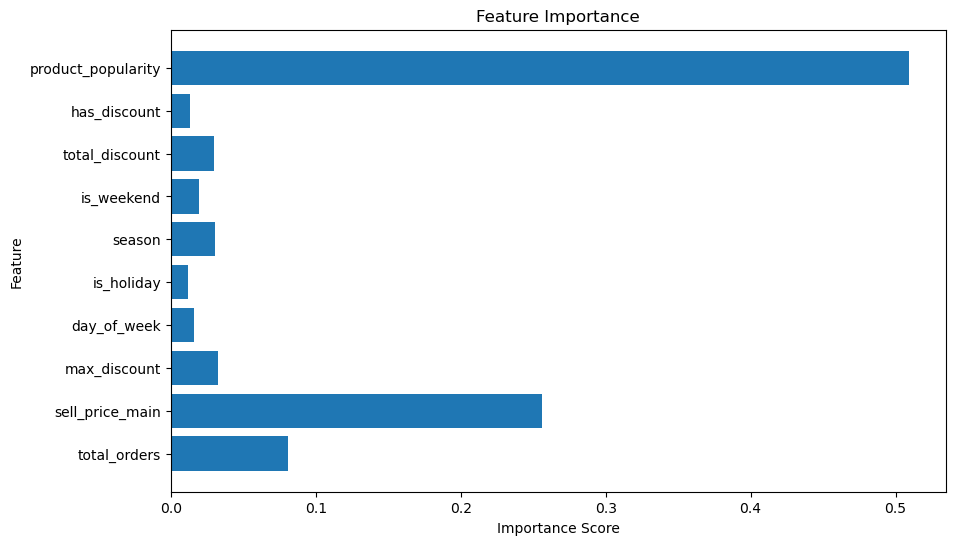

In [16]:
# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(X.columns, best_model.feature_importances_)
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

In [17]:
y_pred = best_model.predict(X_val)

# Calculate MAE
mae = mean_absolute_error(y_val, y_pred)
print(f'Validation MAE: {mae}')

Validation MAE: 29.976907423353957


In [18]:
# Test feature engineering
test['max_discount'] = test[discount_cols].max(axis=1)  # Create 'max_discount' feature
test = test.merge(inventory, on=['unique_id', 'warehouse'], how='left')  # Add inventory details
test = test.merge(calendar, on=['warehouse', 'date'], how='left')  # Add calendar details

# Fill missing 'holiday' values with 0
test['holiday'] = test['holiday'].fillna(0)

# Create time-based features for test data
test['day_of_week'] = test['date'].dt.dayofweek
test['month'] = test['date'].dt.month
test['is_holiday'] = test['holiday'].apply(lambda x: 1 if x == 1 else 0)

# Construct 'id' column for submission (unique_id + date)
test['id'] = test['unique_id'].astype(str) + '_' + test['date'].astype(str)

# Create additional features
test['season'] = test['date'].dt.month % 12 // 3 + 1
test['is_weekend'] = test['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
test['total_discount'] = test[discount_cols].sum(axis=1)
test['has_discount'] = test['total_discount'].apply(lambda x: 1 if x > 0 else 0)

# Merge product_popularity with test
test = test.merge(product_popularity, on='product_unique_id', how='left')

In [20]:
# Prepare test features
X_test = test[['total_orders', 'sell_price_main', 'max_discount', 'day_of_week', 'is_holiday', 'season', 'is_weekend', 'total_discount', 'has_discount', 'product_popularity']]
# Generate predictions
test['sales_hat'] = best_model.predict(X_test)

In [21]:
submission = test[['id', 'sales_hat']]
submission.to_csv('submission.csv', index=False)